# EDA for CHGH dataset

In [9]:
!nvidia-smi

Failed to initialize NVML: Unknown Error


## Setup Environment

In [10]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Library

In [11]:
import sys
import os
# set package path
sys.path.append("/nfs/Workspace/CardiacSeg")

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SqueezeDimd
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.data_loader_utils import load_data_dict_json, split_data_dicts
from datasets.chgh_dataset import get_data_dicts
from datasets.label_dataset import get_multiple_label_data_dicts, multi_label_to_label_pred_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info, get_pids_by_data_dicts
from data_utils.io import load_json, save_json
from expers.preprocess import get_rel_data_dicts

## Prepare data dicts

In [11]:
# # mmwhs data dict json
# from pprint import pprint
# from datasets.mmwhs_dataset import get_data_dicts

# def get_data_by_idxs(data_dicts, idxs):
#     return get_rel_data_dicts([data_dicts[i] for i in idxs])

# data_dicts_dir = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'mmwhs')
# data_dicts_json = os.path.join(data_dicts_dir, 'exp_1.json')
# data_dir = '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train'

# data_dicts = get_data_dicts(data_dir)
# pids = get_pids_by_data_dicts(data_dicts)
# tr_ds, val_ds, tt_ds = split_data_dicts(data_dicts, fold=4, num_fold=5, split_train_ratio=0.75)

# out_data_dicts = {
#     'train' : get_rel_data_dicts(tr_ds),
#     'val' : get_rel_data_dicts(val_ds),
#     'test' : get_rel_data_dicts(tt_ds)
# }

# pprint(out_data_dicts)
# os.makedirs(data_dicts_dir, exist_ok=True)
# save_json(out_data_dicts, data_dicts_json)

In [12]:
from pprint import pprint


def get_data_by_idxs(data_dicts, idxs):
    return get_rel_data_dicts([data_dicts[i] for i in idxs])

data_dicts_json = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'chgh', 'exp_b7_9.json')
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2'

data_dicts = get_data_dicts(data_dir)
pids = get_pids_by_data_dicts(data_dicts)


tr_idx = [5, 9, 10, 12, 13, 14, 18, 20, 21]
val_idx = [0, 16, 17]
tt_idx = [1, 15, 19]

out_data_dicts = {
    'train' : get_data_by_idxs(data_dicts, tr_idx),
    'val' : get_data_by_idxs(data_dicts, val_idx),
    'test' : get_data_by_idxs(data_dicts, tt_idx)
}

pprint(out_data_dicts)
# save_json(out_data_dicts, data_dicts_json)

{'test': [{'image': 'pid_02/pid_02.nii.gz', 'label': 'pid_02/pid_02_gt.nii.gz'},
          {'image': 'pid_106/pid_106.nii.gz',
           'label': 'pid_106/pid_106_gt.nii.gz'},
          {'image': 'pid_1000/pid_1000.nii.gz',
           'label': 'pid_1000/pid_1000_gt.nii.gz'}],
 'train': [{'image': 'pid_08/pid_08.nii.gz',
            'label': 'pid_08/pid_08_gt.nii.gz'},
           {'image': 'pid_27/pid_27.nii.gz',
            'label': 'pid_27/pid_27_gt.nii.gz'},
           {'image': 'pid_30/pid_30.nii.gz',
            'label': 'pid_30/pid_30_gt.nii.gz'},
           {'image': 'pid_52/pid_52.nii.gz',
            'label': 'pid_52/pid_52_gt.nii.gz'},
           {'image': 'pid_56/pid_56.nii.gz',
            'label': 'pid_56/pid_56_gt.nii.gz'},
           {'image': 'pid_57/pid_57.nii.gz',
            'label': 'pid_57/pid_57_gt.nii.gz'},
           {'image': 'pid_110/pid_110.nii.gz',
            'label': 'pid_110/pid_110_gt.nii.gz'},
           {'image': 'pid_1002/pid_1002.nii.gz',
           

In [4]:
# split fold data
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2'
data_dicts_json = os.path.join('/nfs/Workspace/CardiacSeg', 'dataset', 'chgh', 'data_dicts', 'exp_2_2.json')
out_data_dicts_dir = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'chgh')
src_tr_ds, src_val_ds, src_tt_ds = load_data_dict_json(data_dir, data_dicts_json)
data_dicts = [*src_tr_ds, *src_val_ds, *src_tt_ds]


num_fold = 4
data_dicts_fs = []
print(f'split num fold: {num_fold}')
for i in range(num_fold):
    tr_ds, val_ds, tt_ds = split_data_dicts(
        data_dicts,
        fold=i, 
        split_train_ratio=0.8, 
        num_fold=num_fold
    )
    
    out_data_dicts = {
        'train': get_rel_data_dicts(tr_ds),
        'val': get_rel_data_dicts(val_ds),
        'test': get_rel_data_dicts(tt_ds)
    }
    
    # save_json(out_data_dicts, os.path.join(out_data_dicts_dir, f'exp_2_2_f{i}.json'))

load json from /nfs/Workspace/CardiacSeg/dataset/chgh/data_dicts/exp_2_2.json
train files (6): ['pid_27', 'pid_30', 'pid_57', 'pid_110', 'pid_1002', 'pid_1003']
val files (2): ['pid_107', 'pid_108']
test files (2): ['pid_106', 'pid_1000']
split num fold: 4
fold: 0
train files (6): ['pid_57', 'pid_110', 'pid_1002', 'pid_1003', 'pid_107', 'pid_108']
val files (2): ['pid_27', 'pid_30']
test files (2): ['pid_106', 'pid_1000']
fold: 1
train files (6): ['pid_27', 'pid_30', 'pid_1002', 'pid_1003', 'pid_107', 'pid_108']
val files (2): ['pid_57', 'pid_110']
test files (2): ['pid_106', 'pid_1000']
fold: 2
train files (6): ['pid_27', 'pid_30', 'pid_57', 'pid_110', 'pid_107', 'pid_108']
val files (2): ['pid_1002', 'pid_1003']
test files (2): ['pid_106', 'pid_1000']
fold: 3
train files (6): ['pid_27', 'pid_30', 'pid_57', 'pid_110', 'pid_1002', 'pid_1003']
val files (2): ['pid_107', 'pid_108']
test files (2): ['pid_106', 'pid_1000']


In [5]:
# label dataset
# root_data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh'
# data_dir = os.path.join(root_data_dir, 'block_06')
# data_dicts_json = os.path.join(root_data_dir, 'data_dicts', 'exp_2_2.json')

# data_dicts = get_multiple_label_data_dicts(data_dir)
# data_dicts = multi_label_to_label_pred_data_dicts(data_dicts)
# data_dicts

## Show data info

In [6]:
data_dicts_json =  '/nfs/Workspace/CardiacSeg/exps/data_dicts/chgh/exp_b7_9.json'
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3'
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_dicts_json)
ds = [*tr_ds, *val_ds, *tt_ds]

load json from /nfs/Workspace/CardiacSeg/exps/data_dicts/chgh/exp_b7_9.json
train files (9): ['pid_08', 'pid_27', 'pid_30', 'pid_52', 'pid_56', 'pid_57', 'pid_110', 'pid_1002', 'pid_1003']
val files (3): ['pid_08_1', 'pid_107', 'pid_108']
test files (3): ['pid_02', 'pid_106', 'pid_1000']


pid: pid_08
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_08/pid_08.nii.gz
img shape: [512, 512, 341]
img spacing: [0.38085938, 0.38085938, 0.5]
lbl shape: [512, 512, 341]
lbl spacing: [0.38085938, 0.38085938, 0.5]
lbl ids: [0. 1.]


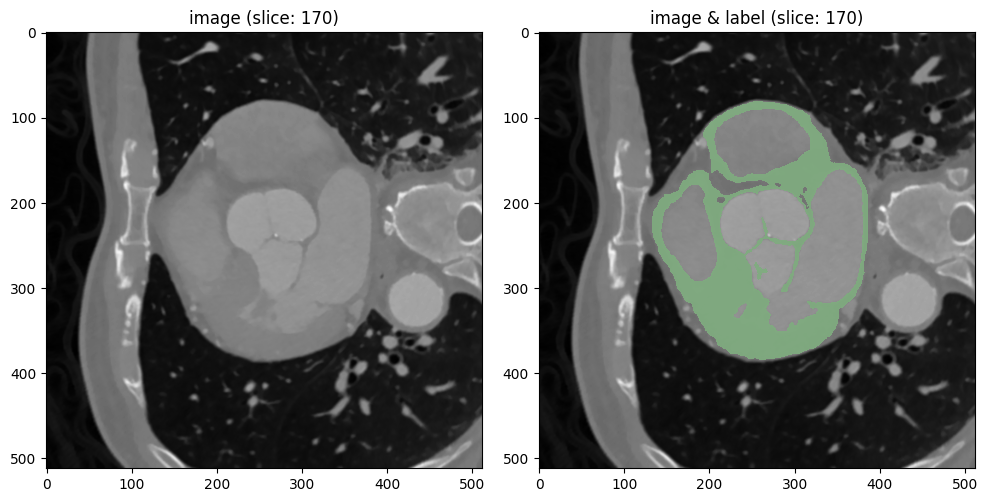

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_27
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_27/pid_27.nii.gz
img shape: [512, 512, 331]
img spacing: [0.3828125, 0.3828125, 0.5]
lbl shape: [512, 512, 331]
lbl spacing: [0.3828125, 0.3828125, 0.5]
lbl ids: [0. 1.]


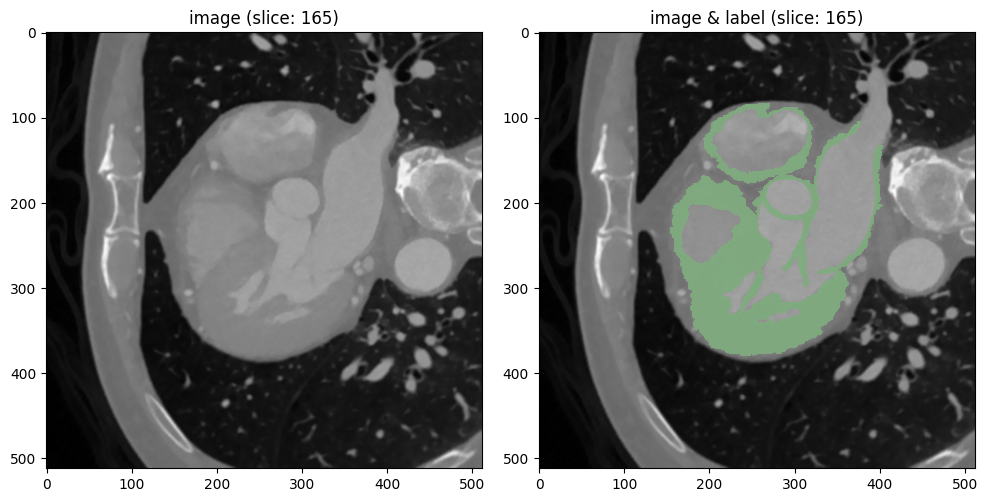

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_30
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_30/pid_30.nii.gz
img shape: [512, 512, 274]
img spacing: [0.3515625, 0.3515625, 0.5]
lbl shape: [512, 512, 274]
lbl spacing: [0.3515625, 0.3515625, 0.5]
lbl ids: [0. 1.]


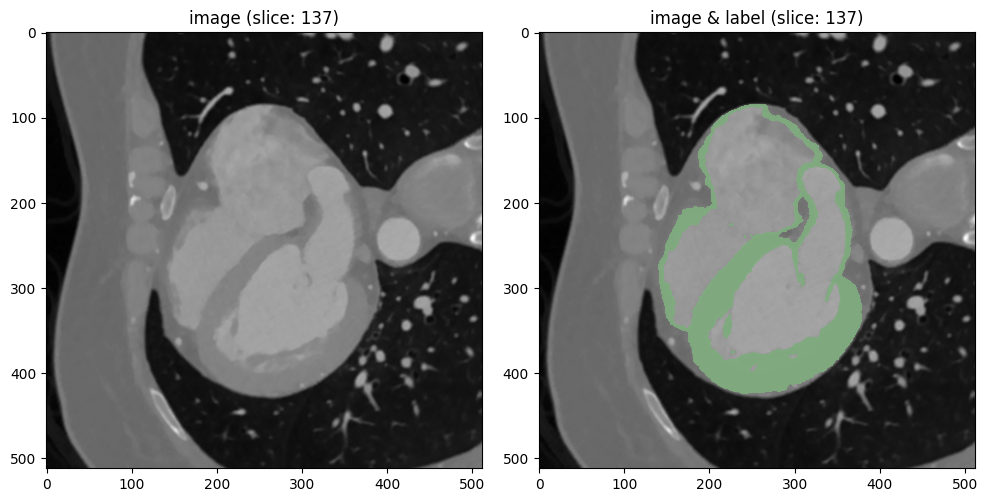

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_52
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_52/pid_52.nii.gz
img shape: [512, 512, 275]
img spacing: [0.34375, 0.34375, 0.5]
lbl shape: [512, 512, 275]
lbl spacing: [0.34375, 0.34375, 0.5]
lbl ids: [0. 1.]


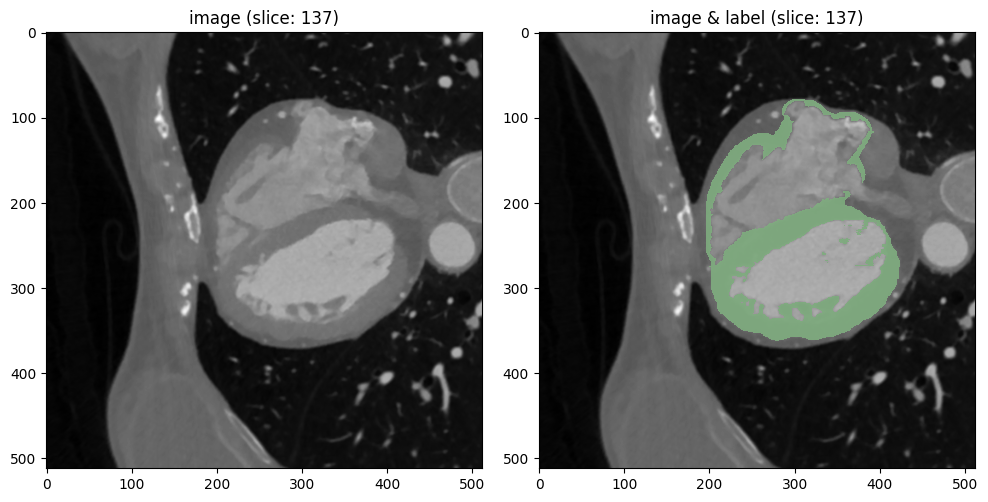

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_56
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_56/pid_56.nii.gz
img shape: [512, 512, 297]
img spacing: [0.36523438, 0.36523438, 0.5]
lbl shape: [512, 512, 297]
lbl spacing: [0.36523438, 0.36523438, 0.5]
lbl ids: [0. 1.]


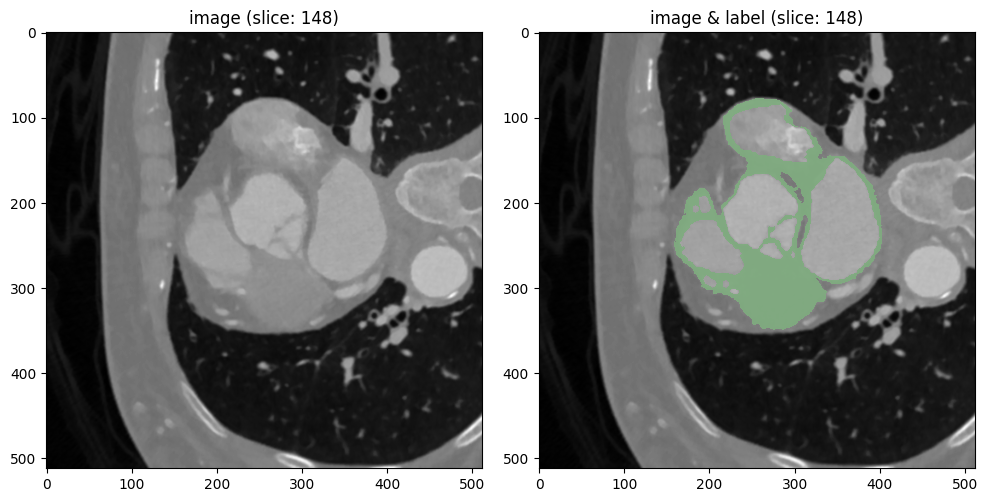

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_57
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_57/pid_57.nii.gz
img shape: [512, 512, 411]
img spacing: [0.47851562, 0.47851562, 0.4]
lbl shape: [512, 512, 411]
lbl spacing: [0.47851562, 0.47851562, 0.4]
lbl ids: [0. 1.]


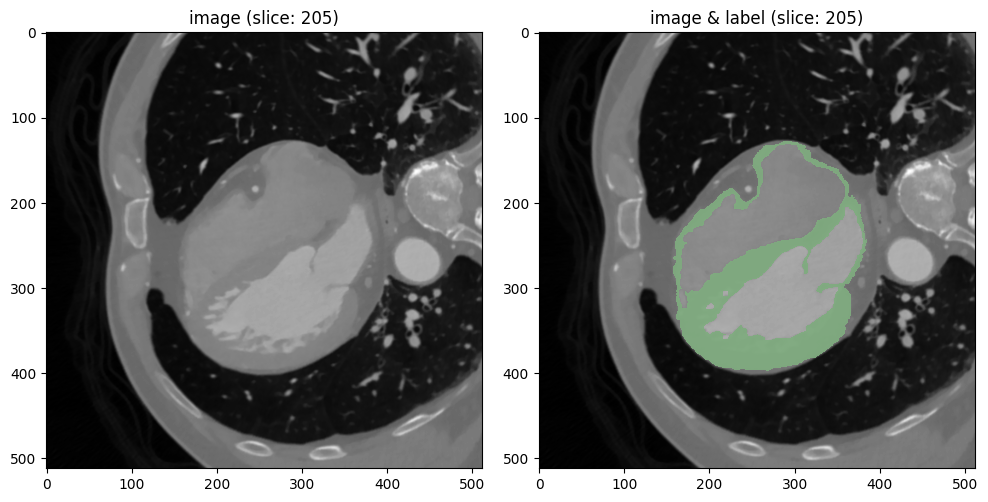

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_110
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_110/pid_110.nii.gz
img shape: [512, 512, 366]
img spacing: [0.37890625, 0.37890625, 0.4]
lbl shape: [512, 512, 366]
lbl spacing: [0.37890625, 0.37890625, 0.4]
lbl ids: [0. 1.]


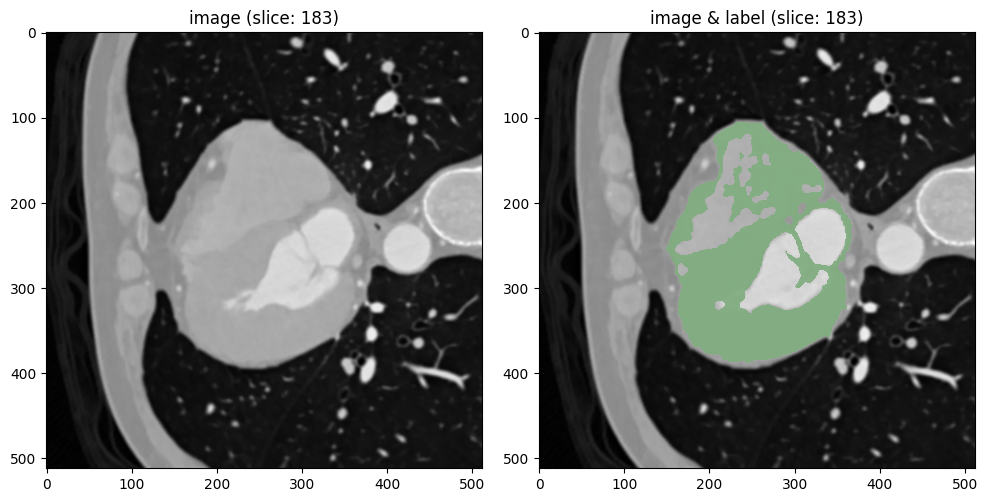

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_1002
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_1002/pid_1002.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


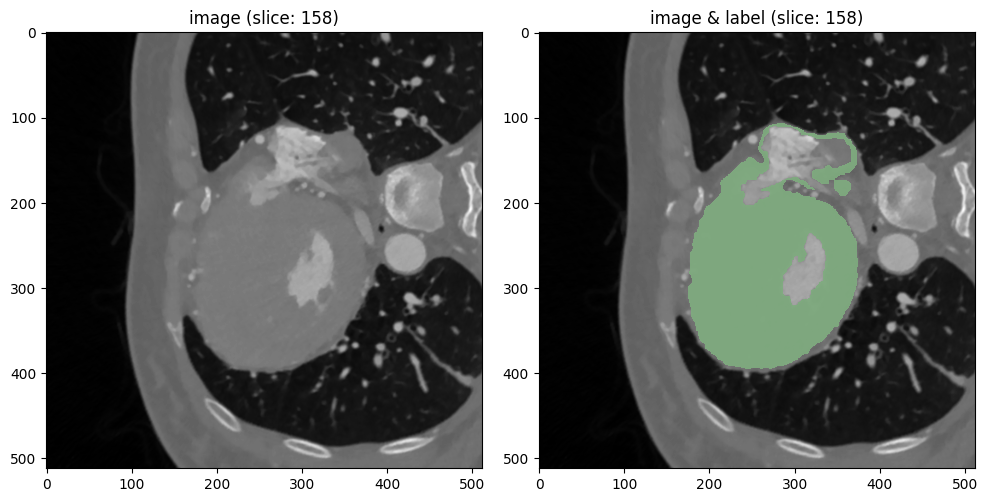

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_1003
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_1003/pid_1003.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


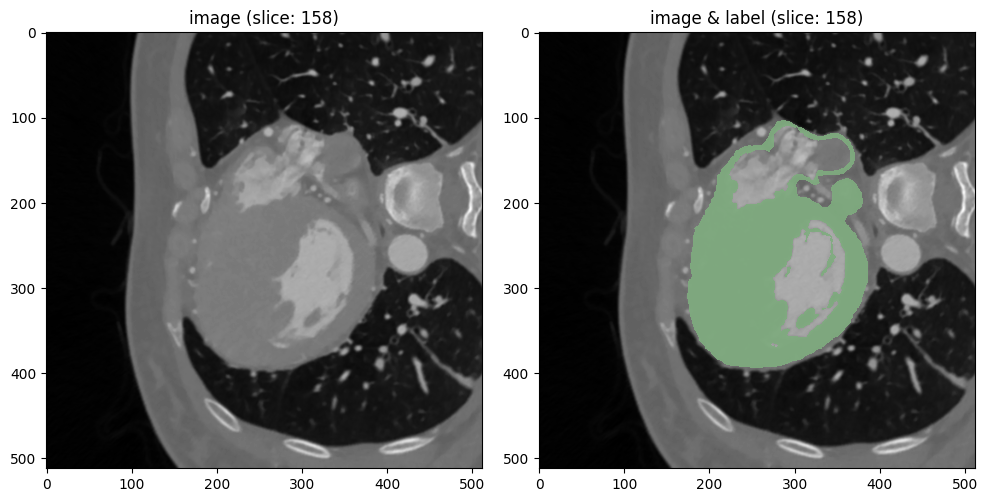

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_08_1
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_08_1/pid_08_1.nii.gz
img shape: [512, 512, 341]
img spacing: [0.41601562, 0.41601562, 0.5]
lbl shape: [512, 512, 341]
lbl spacing: [0.41601562, 0.41601562, 0.5]
lbl ids: [0. 1.]


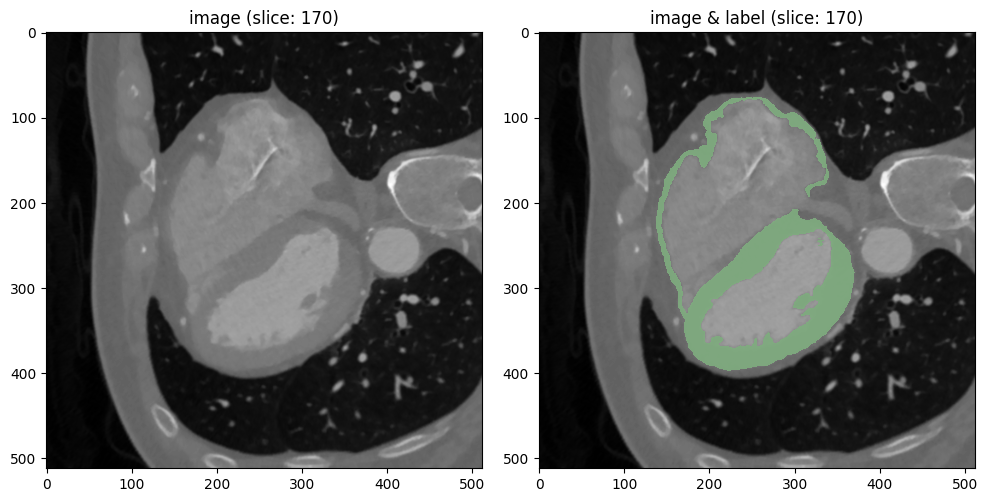

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_107
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_107/pid_107.nii.gz
img shape: [512, 512, 376]
img spacing: [0.33203125, 0.33203125, 0.4]
lbl shape: [512, 512, 376]
lbl spacing: [0.33203125, 0.33203125, 0.4]
lbl ids: [0. 1.]


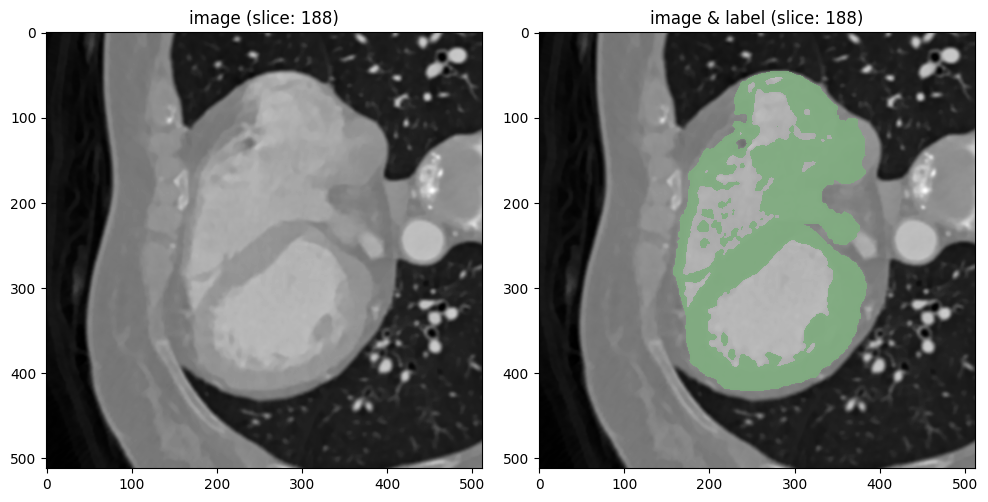

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_108
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_108/pid_108.nii.gz
img shape: [512, 512, 267]
img spacing: [0.3359375, 0.3359375, 0.5]
lbl shape: [512, 512, 267]
lbl spacing: [0.3359375, 0.3359375, 0.5]
lbl ids: [0. 1.]


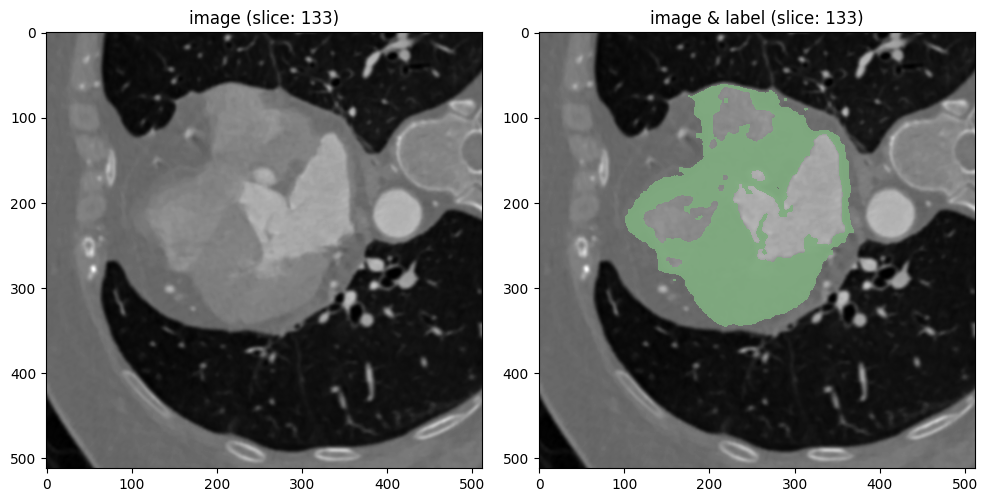

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_02
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_02/pid_02.nii.gz
img shape: [512, 512, 429]
img spacing: [0.38085938, 0.38085938, 0.4]
lbl shape: [512, 512, 429]
lbl spacing: [0.38085938, 0.38085938, 0.4]
lbl ids: [0. 1.]


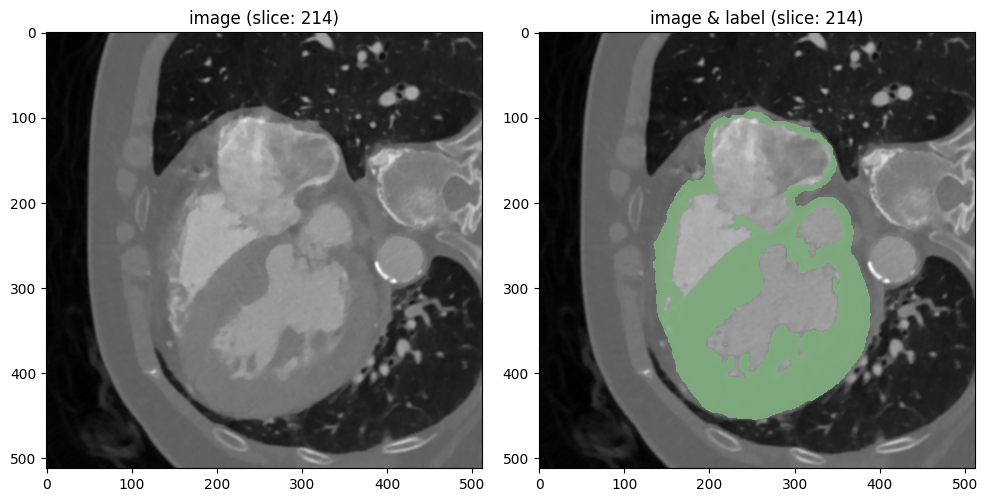

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_106
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_106/pid_106.nii.gz
img shape: [512, 512, 403]
img spacing: [0.42382812, 0.42382812, 0.4]
lbl shape: [512, 512, 403]
lbl spacing: [0.42382812, 0.42382812, 0.4]
lbl ids: [0. 1.]


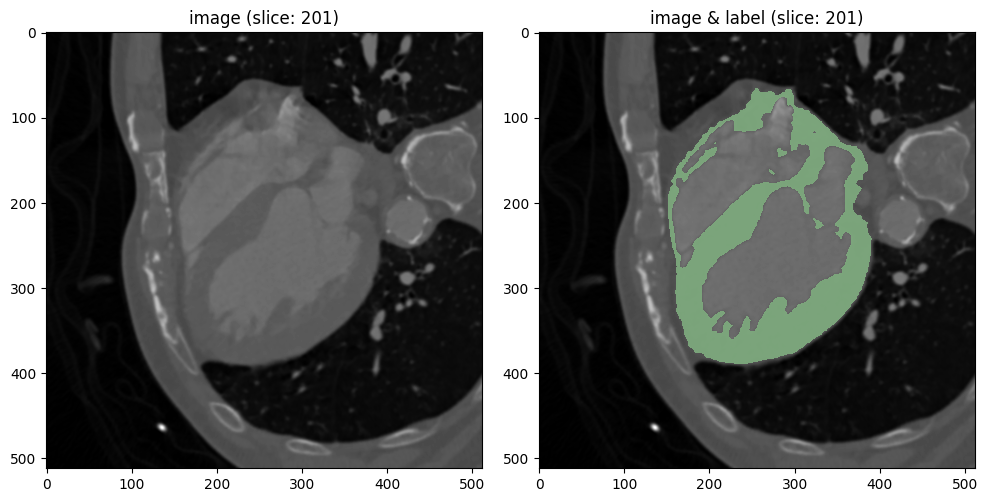

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_1000
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_3/pid_1000/pid_1000.nii.gz
img shape: [512, 512, 357]
img spacing: [0.36914062, 0.36914062, 0.4]
lbl shape: [512, 512, 357]
lbl spacing: [0.36914062, 0.36914062, 0.4]
lbl ids: [0. 1.]


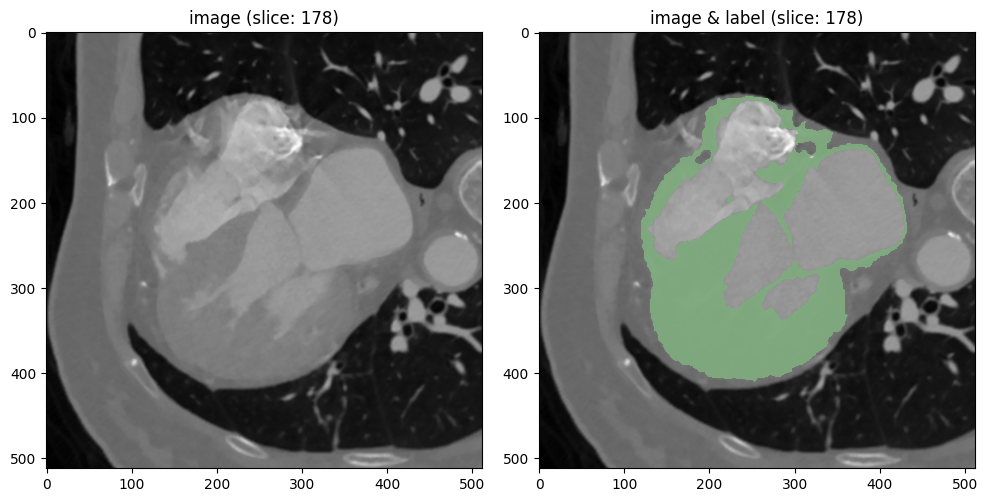

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [7]:
data_info_df = get_data_info(ds)

In [8]:
data_info_df

pid        img_shape                      img_space        lbl_shape  \
0     pid_08  [512, 512, 341]  [0.38085938, 0.38085938, 0.5]  [512, 512, 341]   
1     pid_27  [512, 512, 331]    [0.3828125, 0.3828125, 0.5]  [512, 512, 331]   
2     pid_30  [512, 512, 274]    [0.3515625, 0.3515625, 0.5]  [512, 512, 274]   
3     pid_52  [512, 512, 275]        [0.34375, 0.34375, 0.5]  [512, 512, 275]   
4     pid_56  [512, 512, 297]  [0.36523438, 0.36523438, 0.5]  [512, 512, 297]   
5     pid_57  [512, 512, 411]  [0.47851562, 0.47851562, 0.4]  [512, 512, 411]   
6    pid_110  [512, 512, 366]  [0.37890625, 0.37890625, 0.4]  [512, 512, 366]   
7   pid_1002  [512, 512, 317]        [0.40625, 0.40625, 0.5]  [512, 512, 317]   
8   pid_1003  [512, 512, 317]        [0.40625, 0.40625, 0.5]  [512, 512, 317]   
9   pid_08_1  [512, 512, 341]  [0.41601562, 0.41601562, 0.5]  [512, 512, 341]   
10   pid_107  [512, 512, 376]  [0.33203125, 0.33203125, 0.4]  [512, 512, 376]   
11   pid_108  [512, 512, 267]    [0.3359375, 0.3359375, 0.5]  [512, 512, 267]   
12    pid_02  [512, 512, 429]  [0.38085938, 0.38085938, 0.4]  [512, 512, 429]   
13   pid_106  [512, 512, 403]  [0.42382812, 0.42382812, 0.4]  [512, 512, 403]   
14  pid_1000  [512, 512, 357]  [0.36914062, 0.36914062, 0.4]  [512, 512, 357]   

                        lbl_space     lbl_ids  
0   [0.38085938, 0.38085938, 0.5]  [0.0, 1.0]  
1     [0.3828125, 0.3828125, 0.5]  [0.0, 1.0]  
2     [0.3515625, 0.3515625, 0.5]  [0.0, 1.0]  
3         [0.34375, 0.34375, 0.5]  [0.0, 1.0]  
4   [0.36523438, 0.36523438, 0.5]  [0.0, 1.0]  
5   [0.47851562, 0.47851562, 0.4]  [0.0, 1.0]  
6   [0.37890625, 0.37890625, 0.4]  [0.0, 1.0]  
7         [0.40625, 0.40625, 0.5]  [0.0, 1.0]  
8         [0.40625, 0.40625, 0.5]  [0.0, 1.0]  
9   [0.41601562, 0.41601562, 0.5]  [0.0, 1.0]  
10  [0.33203125, 0.33203125, 0.4]  [0.0, 1.0]  
11    [0.3359375, 0.3359375, 0.5]  [0.0, 1.0]  
12  [0.38085938, 0.38085938, 0.4]  [0.0, 1.0]  
13  [0.42382812, 0.42382812, 0.4]  [0.0, 1.0]  
14  [0.36914062, 0.36914062, 0.4]  [0.0, 1.0]

In [9]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
print('min:', data_shape_df.min().to_list())
print('max:',data_shape_df.max().to_list())
print('mean:',data_shape_df.mean().to_list())

min: [512, 512, 267]
max: [512, 512, 429]
mean: [512.0, 512.0, 340.1333333333333]


In [10]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])

min_z = data_space_df[['z']].min().values[0]
max_z = data_space_df[['z']].max().values[0]

min_z_df = data_space_df.loc[data_space_df['z'] == min_z]
max_z_df = data_space_df.loc[data_space_df['z'] == max_z]

print('sp xyz mean:',data_space_df.mean().to_list())
print('sp min xy min z:', min_z_df.min().to_list())
print('sp max xy min z:', min_z_df.max().to_list())
print('sp min xy max z:', max_z_df.min().to_list())
print('sp max xy max z:', max_z_df.max().to_list())

sp xyz mean: [0.3834635317325592, 0.3834635317325592, 0.46000003814697266]
sp min xy min z: [0.33203125, 0.33203125, 0.4000000059604645]
sp max xy min z: [0.478515625, 0.478515625, 0.4000000059604645]
sp min xy max z: [0.3359375, 0.3359375, 0.5]
sp max xy max z: [0.416015625, 0.416015625, 0.5]


## Statcics

In [12]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=tr_ds,
    transform=base_tf
)

Loading dataset: 100%|██████████| 9/9 [00:48<00:00,  5.38s/it]


In [24]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile=0.1,max_percentile=99.9)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [14]:
print('data target space:')
data_target_space

data target space:


(0.380859375, 0.380859375, 0.5)

In [25]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', 'min_percentile (0.5%)', 'max_percentile (99.5%)']
)
data_intensities_statcics

data intensities statcics:


min    med     max        mean        std  min_percentile (0.5%)  \
0 -827.0  116.0  1613.0  127.986061  74.365562                 -102.0   

   max_percentile (99.5%)  
0                   531.0

## Transform Step

In [48]:
transform_output_dir = './transform_output'
space = [0.7,0.7,1.0]
a_min = -42 #s.data_min_percentile
a_max = 423 #s.data_max_percentile
roi_x, roi_y, roi_z = [128, 128, 128]
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="PLS"),
          # Spacingd(
          #     keys=["image", "label"],
          #     pixdim=space,
          #     mode=("bilinear", "nearest"),
          # ),
          # ScaleIntensityRanged(
          #     keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          # ),
      ]
    )

In [29]:
data = transform(tt_ds[2])

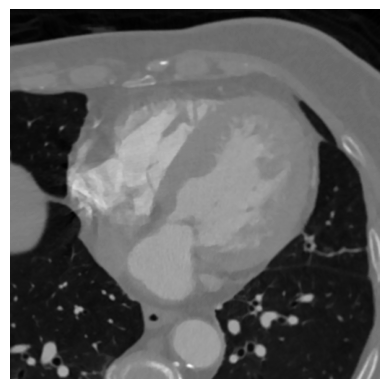

In [41]:
# Origin
plt.imshow(data['image'][0, :,:,150], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "origin.png"),
    bbox_inches='tight',
    pad_inches=0
)

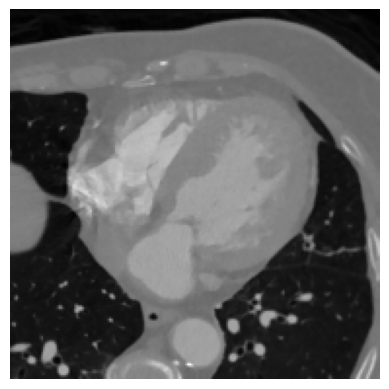

In [45]:
space_transform = Spacingd(
  keys=["image", "label"],
  pixdim=space,
  mode=("bilinear", "nearest"),
)
space_data = space_transform(data)

plt.imshow(space_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "space.png"),
    bbox_inches='tight',
    pad_inches=0
)

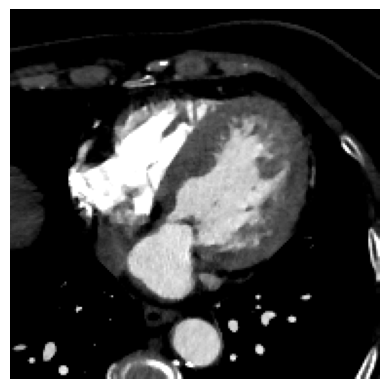

In [46]:
intensity_transform = ScaleIntensityRanged(
  keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
)
intensity_data = intensity_transform(space_data)

plt.imshow(intensity_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "intensity.png"),
    bbox_inches='tight',
    pad_inches=0
)

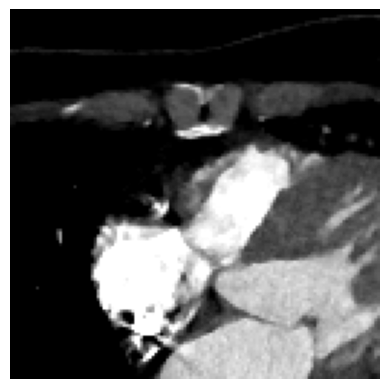

In [51]:
rand_crop_transform = RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=(roi_x, roi_y, roi_z),
    pos=1,
    neg=1,
    num_samples=1,
    image_key="image",
    image_threshold=0,
)

rand_crop_data = rand_crop_transform(intensity_data)
plt.imshow(rand_crop_data[0]['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_crop.png"),
    bbox_inches='tight',
    pad_inches=0
)

In [113]:
!zip -r transform_output.zip transform_output

  adding: transform_output/ (stored 0%)
  adding: transform_output/origin.png (deflated 1%)
  adding: transform_output/space.png (deflated 1%)
  adding: transform_output/intensity.png (deflated 2%)
  adding: transform_output/rand_crop.png (deflated 1%)
  adding: transform_output/rand_flip_axis_0.png (deflated 1%)
  adding: transform_output/rand_flip_axis_1.png (deflated 1%)
  adding: transform_output/rand_flip_axis_2.png (deflated 2%)
  adding: transform_output/rand_rot.png (deflated 1%)
  adding: transform_output/rand_rot_b.png (deflated 2%)
  adding: transform_output/rand_rot_c.png (deflated 2%)
  adding: transform_output/rand_shift_intensity.png (deflated 1%)
  adding: transform_output/rand_crop_2.png (deflated 2%)


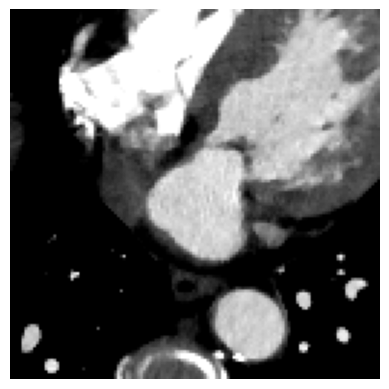

In [112]:
rand_crop_transform = RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=(roi_x, roi_y, roi_z),
    pos=0,
    neg=1,
    num_samples=1,
    image_key="image",
    image_threshold=0,
)

rand_crop_data_2 = rand_crop_transform(intensity_data)
plt.imshow(rand_crop_data_2[0]['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_crop_2.png"),
    bbox_inches='tight',
    pad_inches=0
)

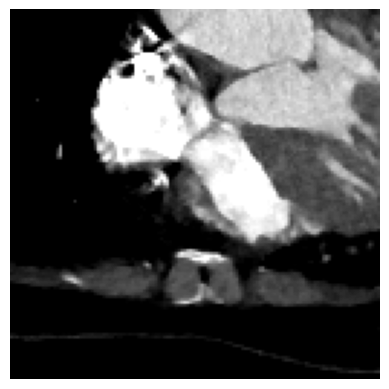

In [54]:
rand_flip_axis_0_transform = RandFlipd(
    keys=["image", "label"],
    spatial_axis=[0],
    prob=1.0,
)

rand_flip_axis_0_data = rand_flip_axis_0_transform(rand_crop_data[0])
plt.imshow(rand_flip_axis_0_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_flip_axis_0.png"),
    bbox_inches='tight',
    pad_inches=0
)

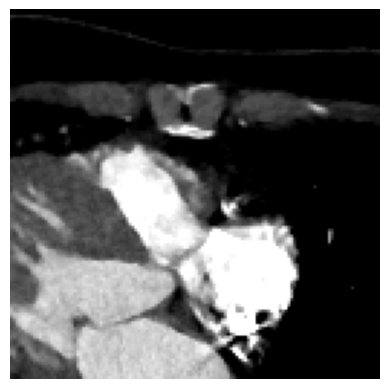

In [56]:
rand_flip_axis_1_transform = RandFlipd(
    keys=["image", "label"],
    spatial_axis=[1],
    prob=1.0,
)

rand_flip_axis_1_data = rand_flip_axis_1_transform(rand_crop_data[0])
plt.imshow(rand_flip_axis_1_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_flip_axis_1.png"),
    bbox_inches='tight',
    pad_inches=0
)

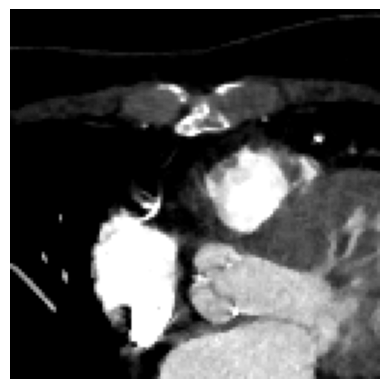

In [57]:
rand_flip_axis_2_transform = RandFlipd(
    keys=["image", "label"],
    spatial_axis=[2],
    prob=1.0,
)

rand_flip_axis_2_data = rand_flip_axis_2_transform(rand_crop_data[0])
plt.imshow(rand_flip_axis_2_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_flip_axis_2.png"),
    bbox_inches='tight',
    pad_inches=0
)

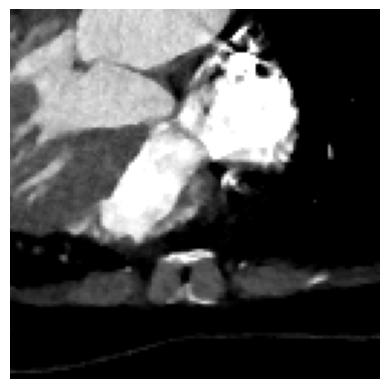

In [114]:
rand_rot_transform = RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
)

rand_rot_data = rand_rot_transform(rand_crop_data[0])
plt.imshow(rand_rot_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_rot_1.png"),
    bbox_inches='tight',
    pad_inches=0
)

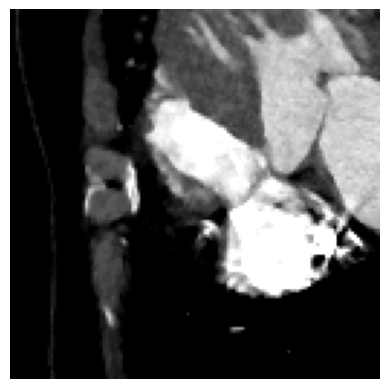

In [116]:
rand_rot_transform = RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
)

rand_rot_data = rand_rot_transform(rand_crop_data[0])
plt.imshow(rand_rot_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_rot_2.png"),
    bbox_inches='tight',
    pad_inches=0
)

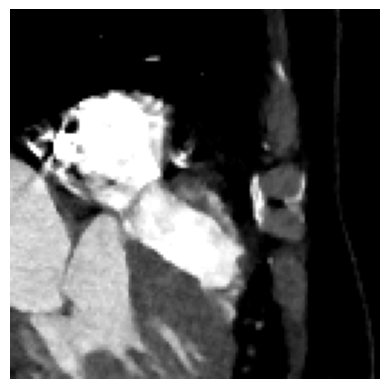

In [117]:
rand_rot_transform = RandRotate90d(
    keys=["image", "label"],
    prob=1,
    max_k=3,
)

rand_rot_data = rand_rot_transform(rand_crop_data[0])
plt.imshow(rand_rot_data['image'][0, :,:,60], cmap='gray')
plt.axis('off')
plt.savefig(
    os.path.join(transform_output_dir, "rand_rot_3.png"),
    bbox_inches='tight',
    pad_inches=0
)

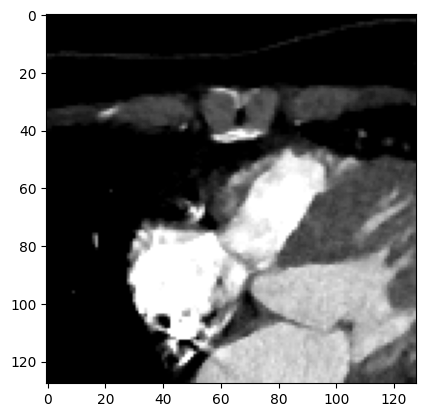

In [98]:
plt.imshow(rand_crop_data[0]['image'][0, :,:,60], cmap='gray')

## Transform

In [17]:
space = [1.0,1.0,1.0]
a_min = -42 #s.data_min_percentile
a_max = 423 #s.data_max_percentile
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          # Spacingd(
          #     keys=["image", "label"],
          #     pixdim=space,
          #     mode=("bilinear", "nearest"),
          # ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          SqueezeDimd(keys=["image", "label"]),
          ToTensord(keys=["image", "label"])
      ]
  )

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


pid: pid_27
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_27/pid_27.nii.gz
img shape: [512, 512, 331]
img spacing: [0.3828125, 0.3828125, 0.5]
lbl shape: [512, 512, 331]
lbl spacing: [0.3828125, 0.3828125, 0.5]
lbl ids: [0. 1.]


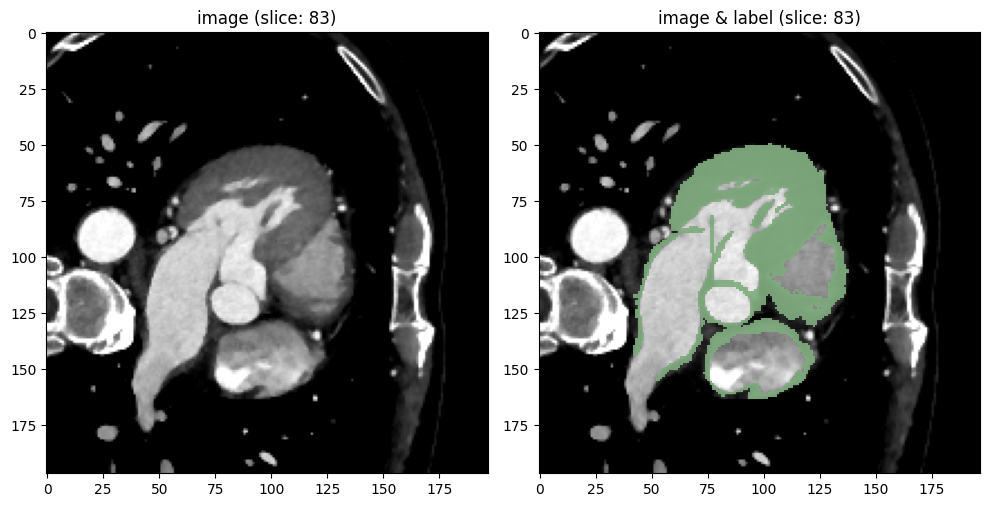

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_30
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_30/pid_30.nii.gz
img shape: [512, 512, 274]
img spacing: [0.3515625, 0.3515625, 0.5]
lbl shape: [512, 512, 274]
lbl spacing: [0.3515625, 0.3515625, 0.5]
lbl ids: [0. 1.]


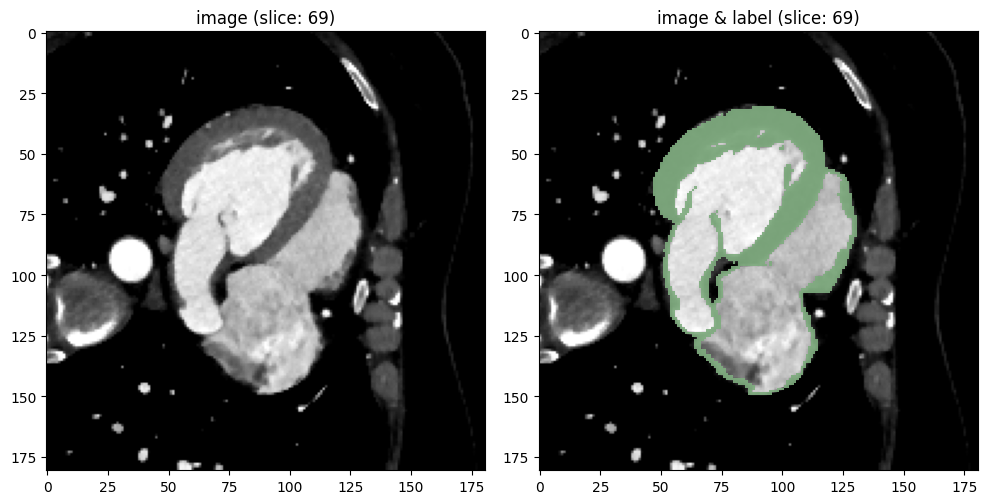

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_57
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_57/pid_57.nii.gz
img shape: [512, 512, 411]
img spacing: [0.47851562, 0.47851562, 0.4]
lbl shape: [512, 512, 411]
lbl spacing: [0.47851562, 0.47851562, 0.4]
lbl ids: [0. 1.]


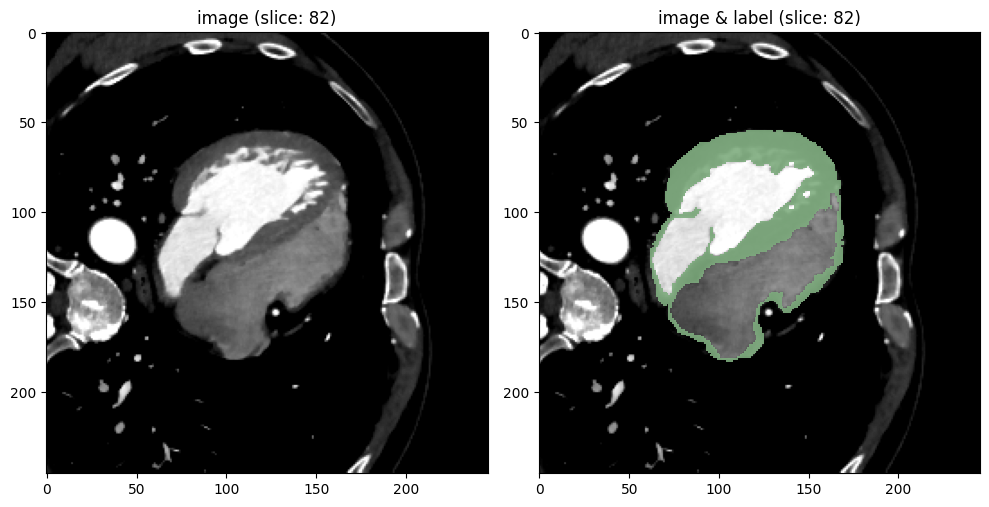

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_110
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_110/pid_110.nii.gz
img shape: [512, 512, 366]
img spacing: [0.37890625, 0.37890625, 0.4]
lbl shape: [512, 512, 366]
lbl spacing: [0.37890625, 0.37890625, 0.4]
lbl ids: [0. 1.]


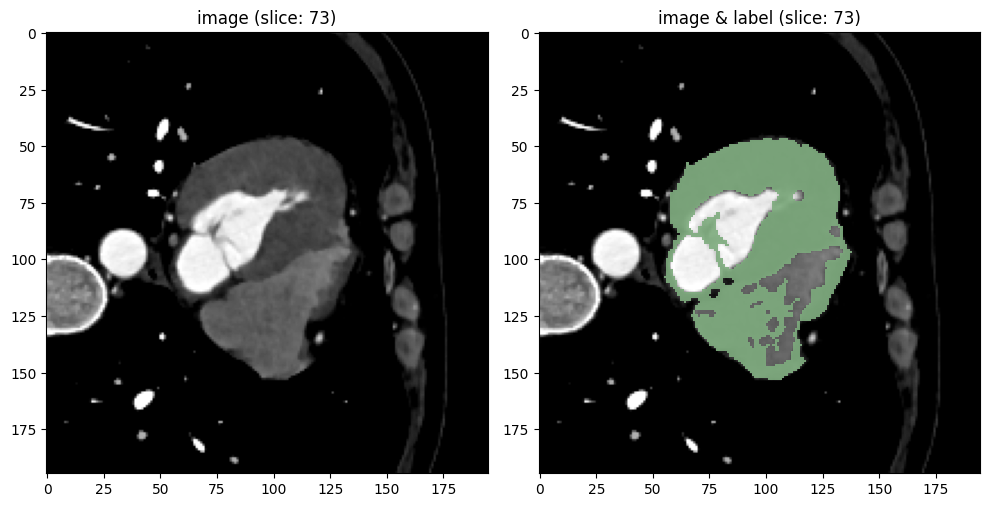

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1002
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1002/pid_1002.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


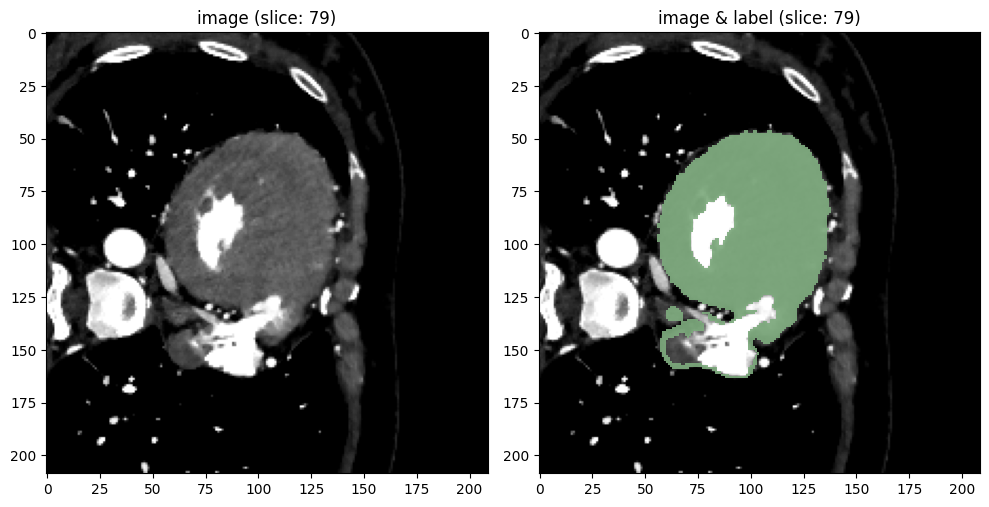

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1003
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1003/pid_1003.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


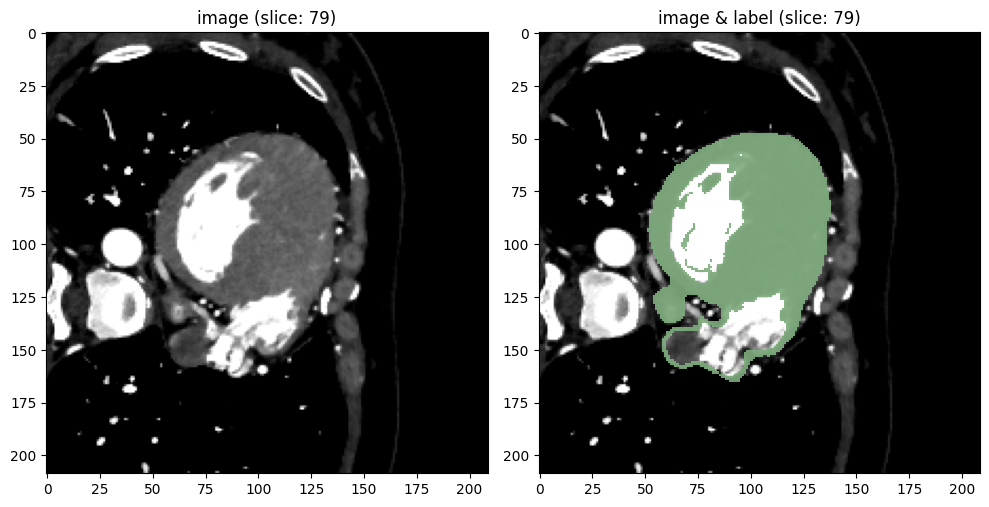

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(


In [29]:
data_info_df = get_data_info(tr_ds, transform)